   # Lab 7
**NAME: SRINATH M KRISHNAN | NET ID: SMK220008**

## Preparation

Use dataset provided in the eLearning

In [2]:
#Extend cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

In [3]:
try:
    h2o.cluster().shutdown()
except:
    pass

In [4]:
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=3, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 hour 13 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,3 months and 11 days
H2O_cluster_name:,H2O_from_python_srinathmurali_45aqwl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.823 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


## Load Data

In [6]:
train=pd.read_csv('SBA_loans_train.csv')
test=pd.read_csv('SBA_loans_test.csv')

In [7]:
for col in train.columns:
    if train[col].isna().any() == True:
        print(col)

City
State
Bank
BankState
NewExist
RevLineCr
LowDoc


In [10]:
cat=['City','State','Bank','BankState','RevLineCr','LowDoc']
num=['NewExist']
for i in cat:
    train[i].fillna(train[i].mode().iloc[0],inplace=True)
    test[i].fillna(test[i].mode().iloc[0],inplace=True)
for i in num:
    test[i].fillna(test[i].median(),inplace=True)

In [12]:
train=h2o.H2OFrame(train)
test=h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [16]:
# Choose which columns to encode
cat_columns = ["City","State","Bank","BankState", "UrbanRural", "FranchiseCode",
               "NewExist", "RevLineCr","LowDoc", "Zip"]
response = "Defaulted"

train[cat_columns+[response]] = train[cat_columns+[response]].asfactor()
test[cat_columns+[response]] = test[cat_columns+[response]].asfactor()
train

City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
Huntsville,AL,35811,"BUSINESS LOAN CENTER, LLC",FL,621310,73,1,2,2,1,0,1,N,N,25000,0,25000,21250,1
SCOTTSDALE,AZ,85254,WELLS FARGO BANK NATL ASSOC,CA,0,84,3,2,0,0,0,0,N,N,52000,0,52000,46800,1
BANGOR,ME,4401,BANGOR SAVINGS BANK,ME,323110,84,9,1,0,0,1,1,,Y,150000,0,150000,127500,0
AVONDALE,AZ,85323,NATIONAL BANK OF ARIZONA,AZ,722110,27,20,1,0,20,10625,2,Y,N,186959,0,100000,50000,1
HAMMOND,LA,70403,"BIZCAPITAL BIDCO II, LLC",LA,0,60,1,1,0,0,1,1,,Y,50000,0,50000,40000,0
BURNSVILLE,MN,55337,SPEDCO,MN,621330,240,2,1,4,2,1,1,,N,266000,0,268000,268000,0
"COEUR D'ALENE,",ID,83814,"PANHANDLE AREA COUNCIL, INC.",ID,0,240,24,2,24,0,1,0,N,N,343000,0,343000,343000,0
TRENTON,NJ,8638,WELLS FARGO BANK NATL ASSOC,SD,0,12,5,1,0,0,1,0,T,N,25000,0,25000,12500,0
MIAMI,FL,33134,BANK OF AMERICA NATL ASSOC,NC,236118,48,1,2,0,1,0,1,N,N,10177,0,10000,5000,1
WATERTOWN,MA,2472,CITIZENS BANK NATL ASSOC,RI,512110,60,4,1,0,4,0,1,N,N,50000,0,50000,25000,0


## Question 1

Train H2O `H2OGradientBoostingEstimator` with parameters:
```
nfolds=5,
ntrees=500,
stopping_rounds=5,
stopping_metric='AUCPR',
seed=1234,
keep_cross_validation_predictions = False
```
Display model performance on `test` dataset using `model_performance` function.

In [18]:
from h2o.estimators import H2OGradientBoostingEstimator

In [19]:
predictors = train.columns
predictors.remove("Defaulted")
print("Predictor columns:", predictors)
response_col = "Defaulted"
model = H2OGradientBoostingEstimator(
    nfolds=5,
    ntrees=500,
    stopping_rounds=5,
    stopping_metric='AUCPR',
    seed=1234,
    keep_cross_validation_predictions=False
)

# Train the model
model.train(predictors, response_col, training_frame= train)

model_summary = model.summary()




Predictor columns: ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [23]:
print("Best accuracy threshold:",model.model_performance(test).accuracy()[0][0],"\n",
      " Accuracy:",
      model.model_performance(test).accuracy()[0][1])
print("Best F1 threshold:",model.model_performance(test).F1()[0][0],"\n",
      " F1:",
      model.model_performance(test).F1()[0][1])
print("Model AUC:", model.model_performance(test).auc())
print("Model AUCPR:", model.model_performance(test).aucpr())
model.model_performance(test).confusion_matrix()

Best accuracy threshold: 0.44504755097513365 
  Accuracy: 0.946884230755543
Best F1 threshold: 0.3892414632676925 
  F1: 0.8465736810187993
Model AUC: 0.9762271238516036
Model AUCPR: 0.9069725200413814


,0,1,Error,Rate
0,89572.0,3117.0,0.0336,(3117.0/92689.0)
1,2955.0,16752.0,0.1499,(2955.0/19707.0)
Total,92527.0,19869.0,0.054,(6072.0/112396.0)


## Question 2

Use model from Question 1 to answer Q#2.

- Calculate and display permutation feature importance for the model using **test** dataset
- What is most important feature?
- Can you tell how feature is impacting (direction) probability? If yes, specify the direction. If not, explain why not.

/opt/anaconda3/lib/python3.9/site-packages/h2o/frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


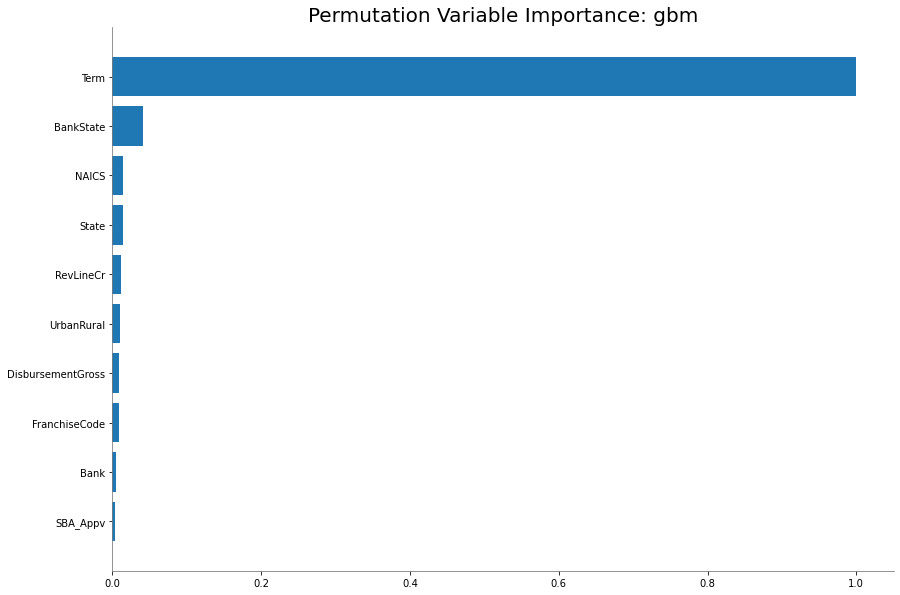

In [24]:
# calculate importance
permutation_varimp = model.permutation_importance(train, use_pandas=True)

# plot permutation importance (bar plot)
model.permutation_importance_plot(train);


The most important feature according to the permutation importance graph is "Term". This feature has the highest importance score, indicating it has the most significant impact on the model's predictions.

Permutation importance measures how the model's accuracy decreases when the values of a single feature are shuffled randomly. However, it does not provide information about the direction of the feature's impact on the target variable. To understand the direction (positive or negative impact), one would typically look at the feature's coefficient in a linear model or use other techniques like Partial Dependence Plots (PDPs), SHAP values, or by examining the decision trees in the case of tree-based models. Since permutation importance only tells us the importance of the feature in making accurate predictions without any indication of how the feature is influencing the probability (whether it's increasing or decreasing it), we cannot specify the direction of impact from this graph alone.

## Question 3

Calculate and plot PDP plot for the following columns: `"UrbanRural","SBA_Appv","DisbursementGross"`

You might find using following parameters useful: `nbins=52,figsize=(10, 10)`

What is your conclusion for each of the variables?

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

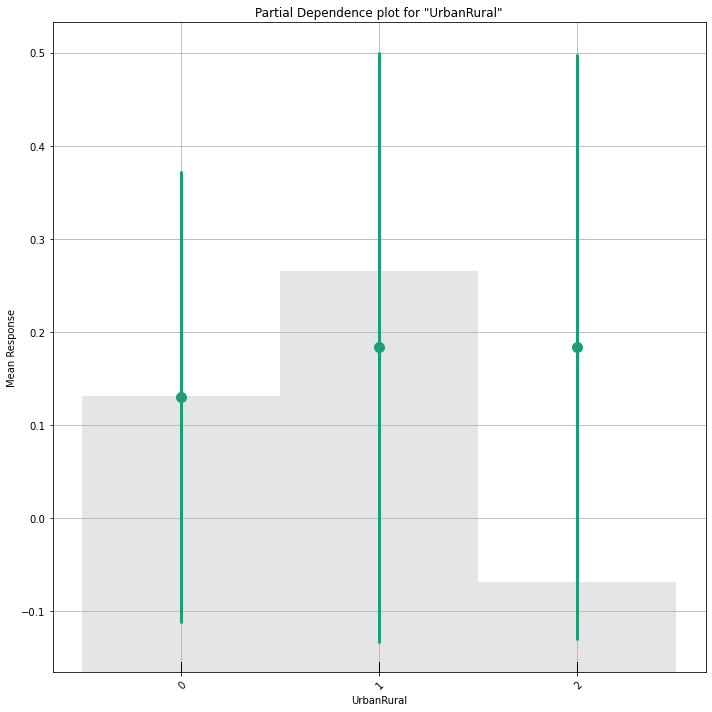

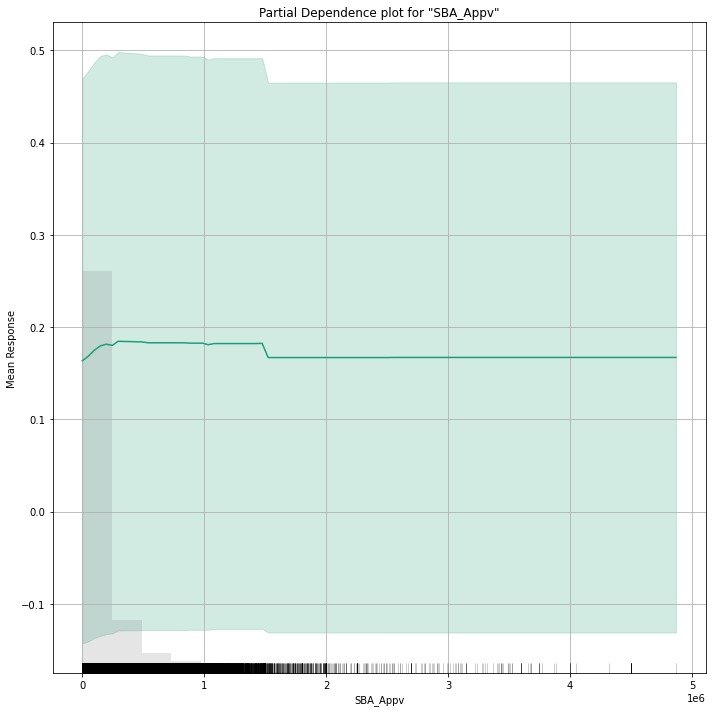

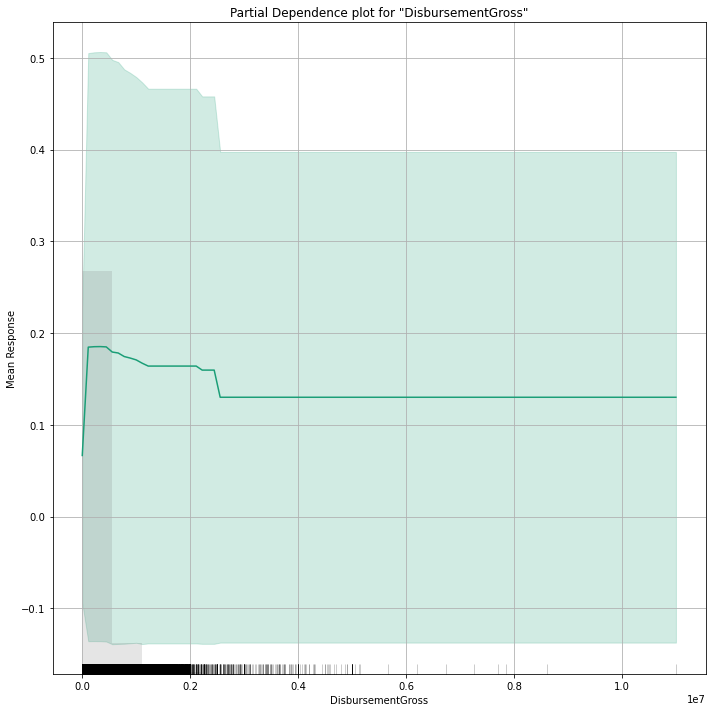

In [25]:
#model.partial_plot(data = test, cols = ["UrbanRural","SBA_Appv","DisbursementGross"])
model.explain(train,columns=["UrbanRural","SBA_Appv","DisbursementGross"],include_explanations='pdp',figsize=(10,10));

UrbanRural Feature:
The Partial Dependence Plot for the "UrbanRural" feature displays discrete levels, suggesting that this is a categorical variable. The graph indicates a measurable impact on the predictive model based on the classification of an observation as either urban or rural. Although the exact categorizations are not labeled, there is a clear differentiation in the predicted outcome that correlates to this feature. To fully interpret the implications, further details are required to associate the levels with their respective urban or rural contexts.

SBA_Appv Feature:
The plot for the "SBA_Appv" feature, presumed to represent the Small Business Administration approval amounts, exhibits a negative trend in the mean prediction as the approval amount increases, stabilizing beyond a certain threshold. This pattern indicates that the model's predicted value is inversely related to the SBA approval amount up to a saturation point, beyond which the approval amount exerts negligible influence on the model's prediction. This could be indicative of a point of diminishing returns in the predictive model concerning the SBA approval amounts.

DisbursementGross Feature:
For the "DisbursementGross" feature, which is likely tied to the total amount disbursed, the Partial Dependence Plot reveals an initial decline in the model's mean response as the disbursement amount increases. However, this trend levels off at higher amounts, suggesting a plateau effect. The implications here are that while increases in the disbursement amount may be associated with lower predicted values by the model initially, beyond a certain disbursement level, further increases do not substantially alter the predictive outcome. This non-linear relationship highlights a limit to the influence of disbursement amount on the model's predictions.

## Question 4

Calculate and display summary plot of Shapley values. Use `test` dataset to calculate Shapley values.

- What is the most important feature based on Shapley values?
- Why "Zip" feature is not rated at the top when many of the observations have significant high/low Shapley values?

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

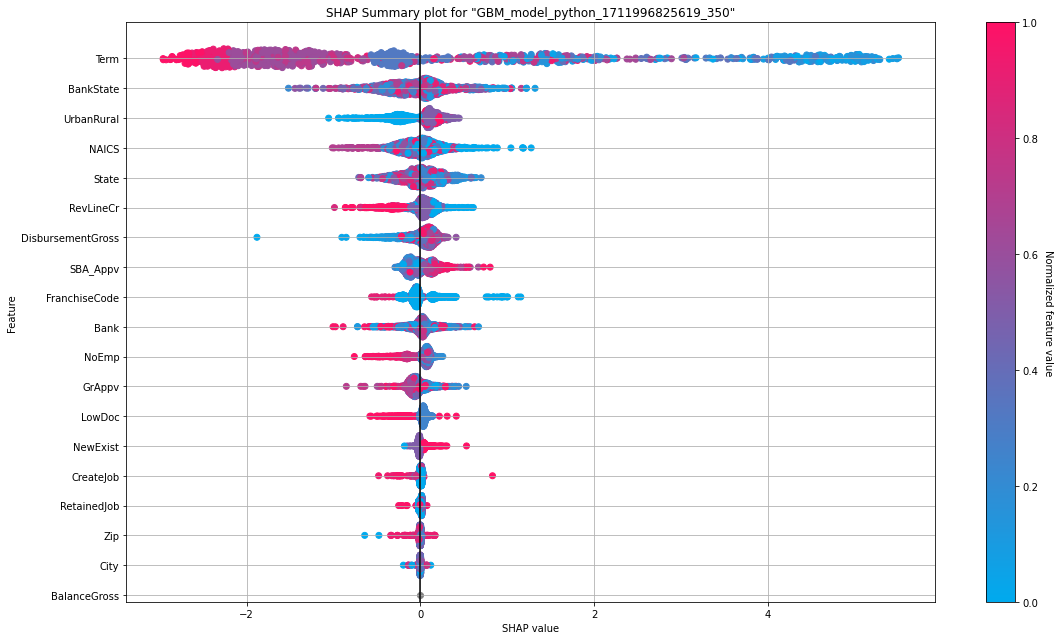

In [26]:
model.explain(test,include_explanations='shap_summary');

The most important feature, as indicated by the SHAP values, is "Term". It is positioned at the top of the plot and has a wide range of SHAP values, both positive and negative, which shows it has a significant impact on the model's output.

The "Zip" feature does not appear at the top of the plot, despite many observations having significant high or low SHAP values, because SHAP values consider both the impact and the consistency of the impact across predictions. While "Zip" may have some high magnitude SHAP values, it may not consistently be an influential feature across all the predictions, and therefore its average impact may be less than other features. The SHAP summary plot aggregates the SHAP values over all the data points, and the color indicates the feature value (high or low). A feature like "Zip" might have extreme values in some cases, but if these do not consistently affect the model’s output across the dataset, the average impact of "Zip" might be smaller, thus ranking it lower in overall importance compared to features that consistently and substantially shift the model's output, like "Term".

## Question 5

Plot individual Shapley values plots for records 0,1 and 4 in test dataset, for the total of 3 plots.
Explain each plot in terms of what are most influential features and how they impact model prediction.

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

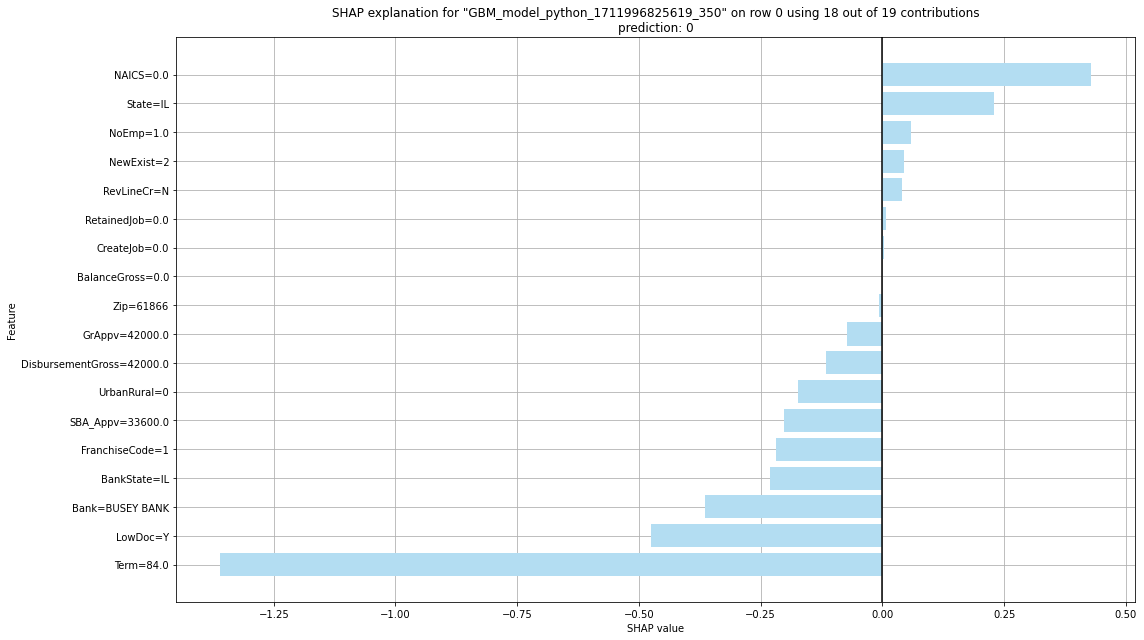

In [27]:
model.explain_row(test,row_index=0,include_explanations='shap_explain_row');

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

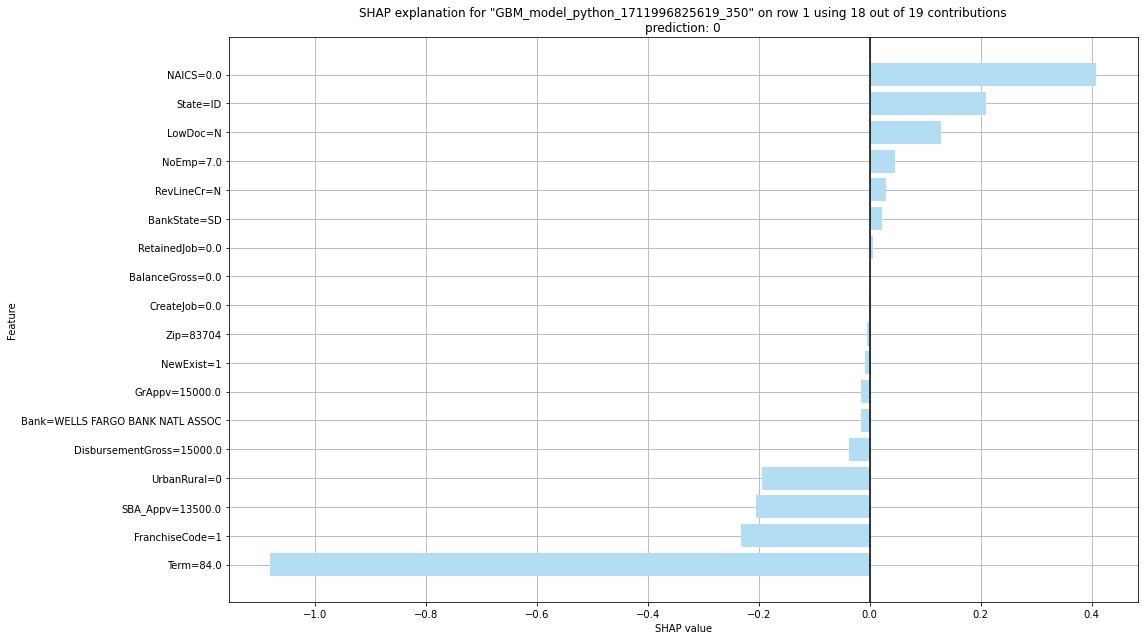

In [28]:
model.explain_row(test,row_index=1,include_explanations='shap_explain_row');

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

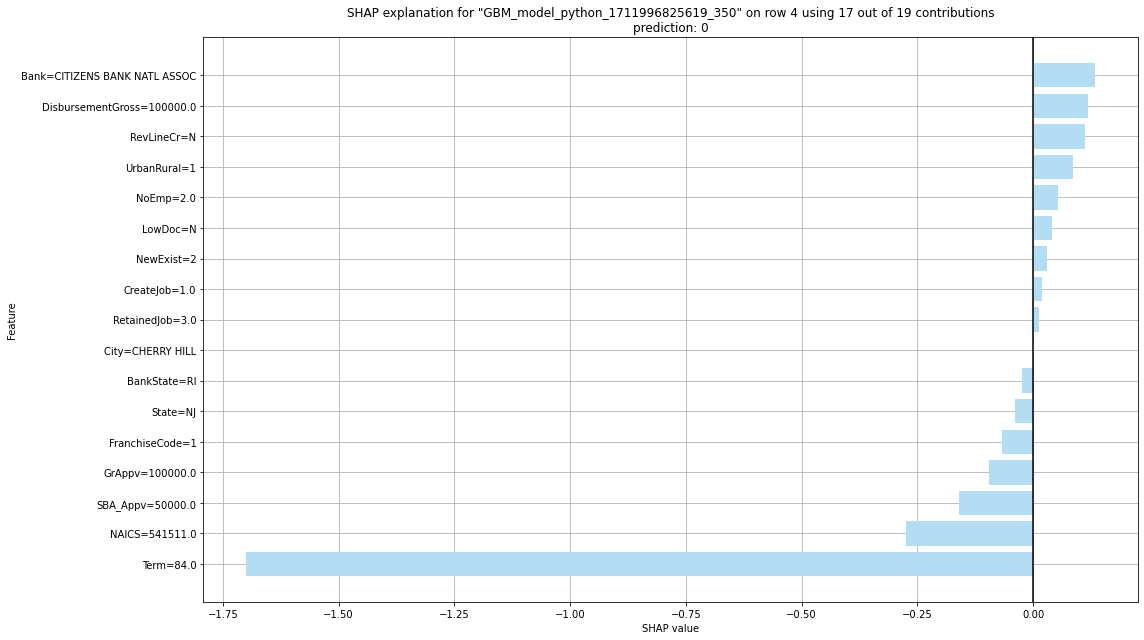

In [29]:
model.explain_row(test,row_index=4,include_explanations='shap_explain_row');

Record 0:

Most influential feature: The "Term" feature has the most substantial negative impact on the model prediction for this particular record, indicating that the longer the term, the less likely the model is to predict a positive outcome for this record.

Other influential features: "Bank" and "BankState" also seem to have a considerable negative impact, along with "FranchiseCode" and "SBA_Appv". The negative SHAP values suggest these features contribute to decreasing the probability of the outcome the model is predicting.

Impact on model prediction: The accumulated negative SHAP values from these features together drive the model's prediction towards zero (assuming that zero is the base or negative class in this context).

Record 1:

Most influential feature: "Term" again appears to be the most influential feature with a substantial negative SHAP value.

Other influential features: "FranchiseCode" and "SBA_Appv" also show notable negative contributions, while "DisbursementGross" and "GrAppv" have smaller but still negative impacts.

Impact on model prediction: The negative contributions of these top features likely push the model's prediction towards zero, similar to Record 0, indicating that these factors reduce the likelihood of a positive outcome.

Record 4:

Most influential feature: The "Term" feature has the largest negative contribution, consistent with its influence in the previous plots.

Other influential features: In this record, "NAICS" and "SBA_Appv" have large negative SHAP values, which means they also significantly contribute to a lower prediction outcome.

Impact on model prediction: The combined negative effects of these features suggest the model is inclined to predict the negative class for this record.

## Question 6

Train single decision tree surrogate model with 4 levels (depth 4) and plot the result.

If you run into problem with using Graphviz, you can generate the png file without it, look for below code in the documentation:
```
java -cp h2o-genmodel.jar hex.genmodel.tools.PrintMojo --tree 0 -i "/path/to/model.zip" -o tree.png --format png
open tree.png
```
Documentation:

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html#viewing-a-mojo-model


In [19]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

dt = H2ORandomForestEstimator(model_id="surrogate.hex",
                              ntrees=1, max_depth=4,
                              sample_rate=1,
                              categorical_encoding="auto",
                              mtries=19, #number of features in the dataset
                              min_rows=20 # use min rows to prevent small leaf nodes and fitting noise
                             )
dt.train(y=response_col, training_frame=train, x=predictors);

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [20]:
import os
import subprocess
from IPython.display import Image
def generateTreeImage(model, tree_number):
    # Download MOJO
    mojo_path = model.download_mojo(get_genmodel_jar=True)
    directory = os.path.dirname(mojo_path)
    h2o_jar_path = os.path.join(directory, "h2o-genmodel.jar")
    # Create Graphviz file
    gv_file_path = os.path.join(directory, "decision_tree.gv")
    gv_call = " ".join(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree", str(tree_number), "-i", mojo_path , "-o", gv_file_path])
    result = subprocess.call(gv_call, shell=True)

    #result = subprocess.call(["ls", gv_file_path], shell = False)
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o decision_tree.png"], shell=False)
    #result = subprocess.call(["ls"," decision_tree.png"], shell = False)

    return Image(" decision_tree.png")

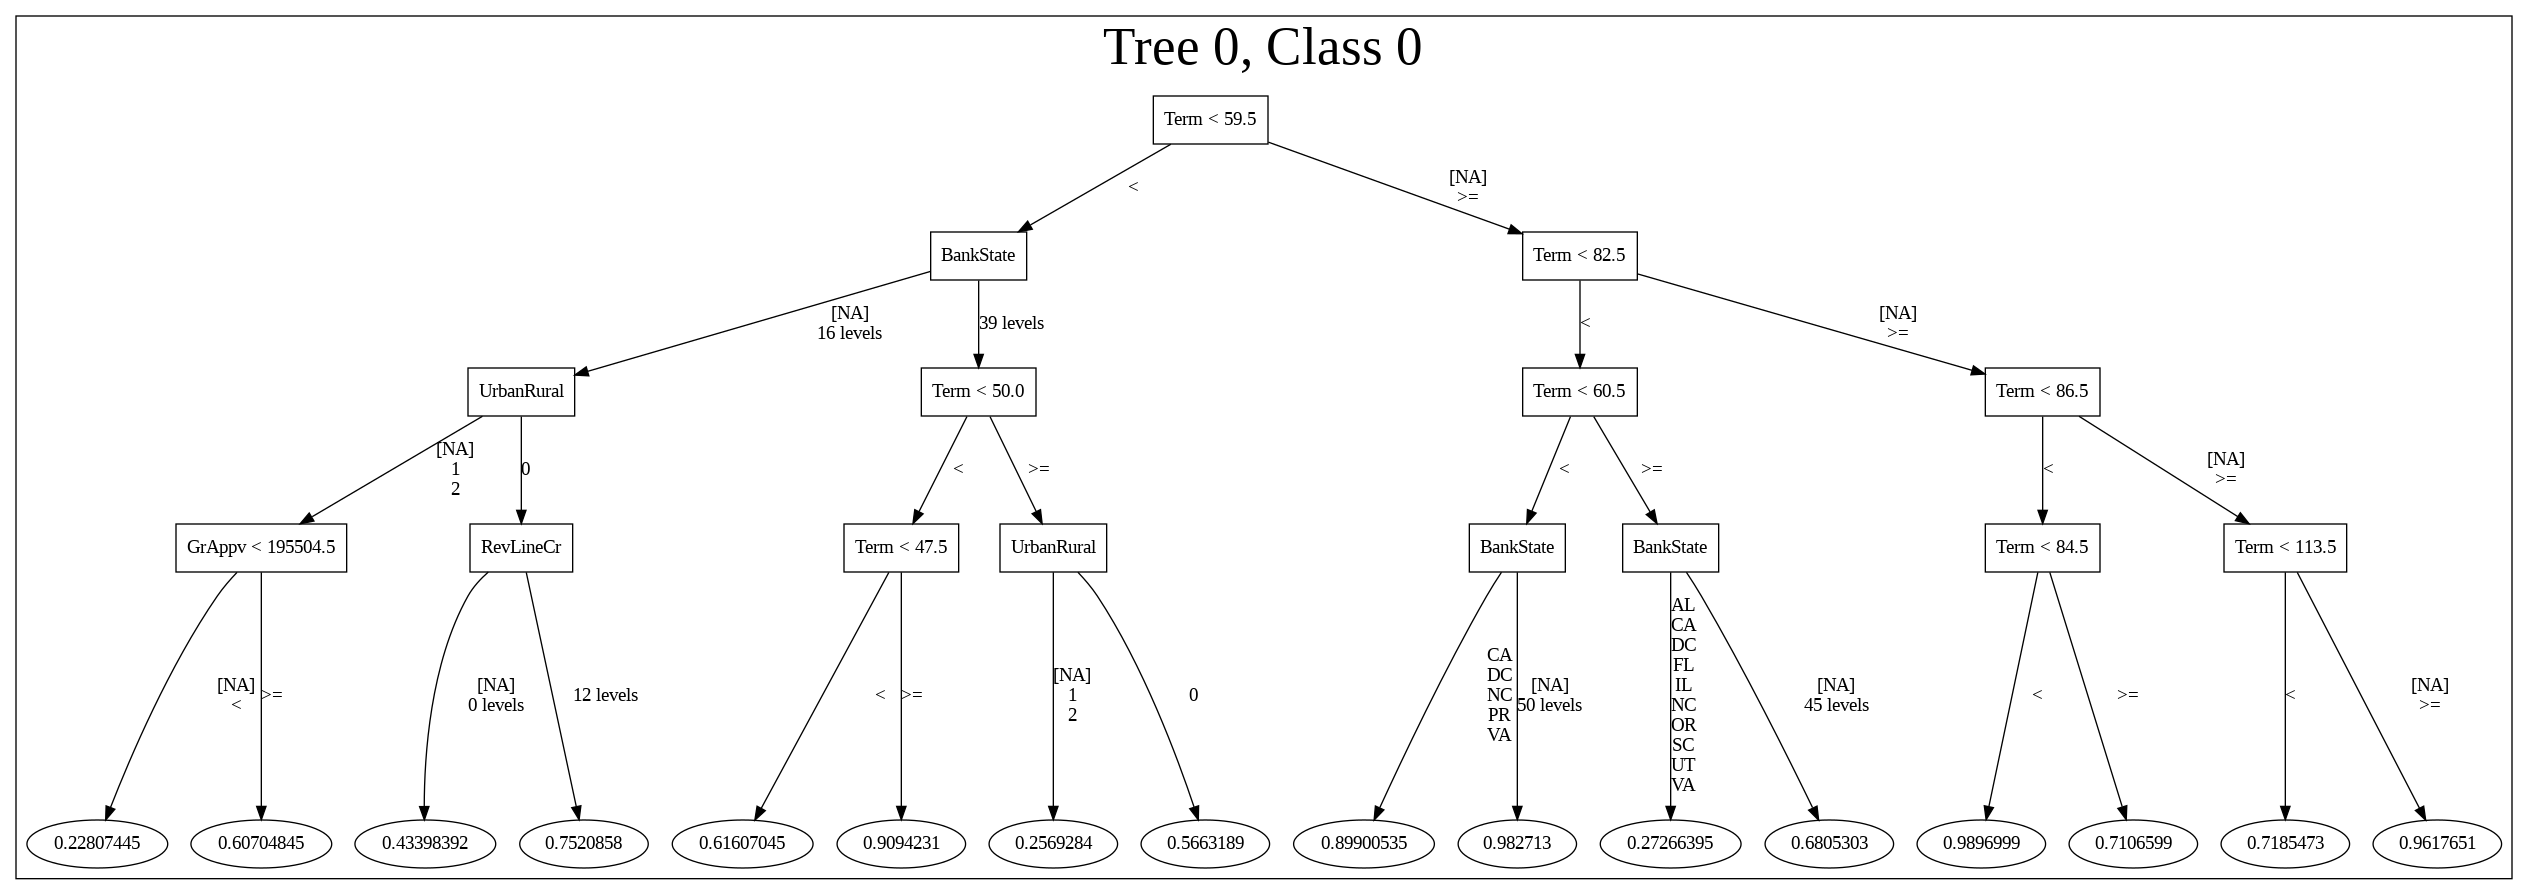

In [23]:
generateTreeImage(dt, 0)